🧪 Processing Images: 100%|██████████| 11577/11577 [1:28:29<00:00,  2.18img/s, last=6K9.jpg, kernel=3, avg_ssim=0.9079]                           
2025-05-17 14:17:58,774 - 
✅ Average SSIM: 90.79% across 11577 images.


Image,Path,Kernel,SSIM
,DATASET_split\testing\ADENOCARCINOMA\25_2.jpg,"(3, 3)",0.9407
,DATASET_split\testing\ADENOCARCINOMA\26_11.jpg,"(5, 5)",0.8916
,DATASET_split\testing\ADENOCARCINOMA\26_13.jpg,"(7, 7)",0.8888
,DATASET_split\testing\ADENOCARCINOMA\26_23.jpg,"(7, 7)",0.8629
,DATASET_split\testing\ADENOCARCINOMA\26_31.jpg,"(5, 5)",0.9192
,DATASET_split\testing\ADENOCARCINOMA\26_34.jpg,"(7, 7)",0.9147
,DATASET_split\testing\ADENOCARCINOMA\27C5.jpg,"(5, 5)",0.8675
,DATASET_split\testing\ADENOCARCINOMA\27D2.jpg,"(5, 5)",0.8814
,DATASET_split\testing\ADENOCARCINOMA\27E1.jpg,"(5, 5)",0.9157
,DATASET_split\testing\ADENOCARCINOMA\27F5.jpg,"(7, 7)",0.8713

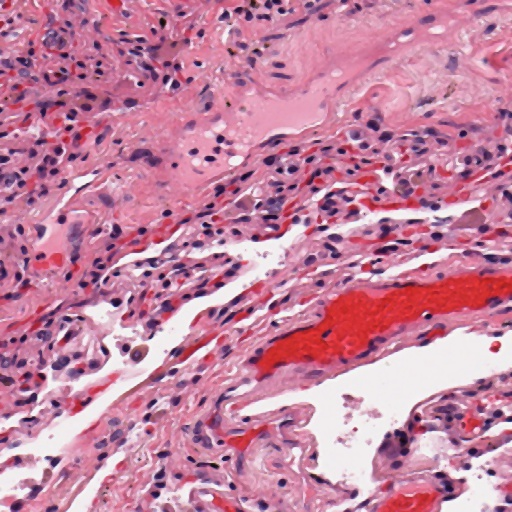
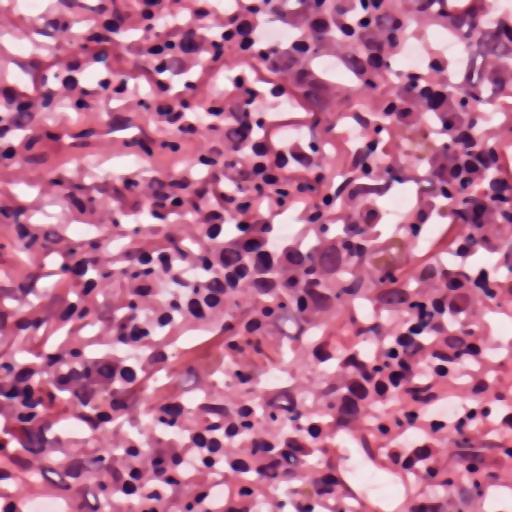
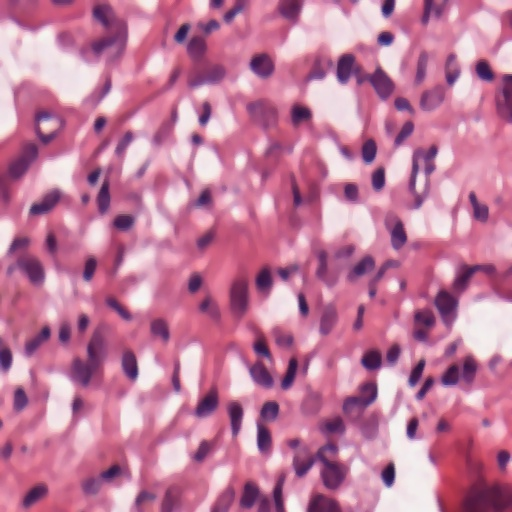
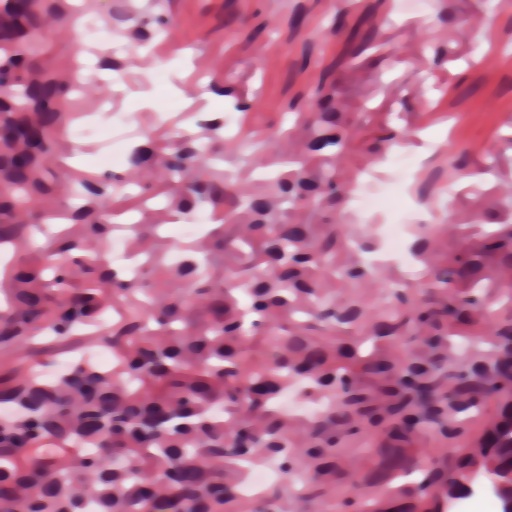
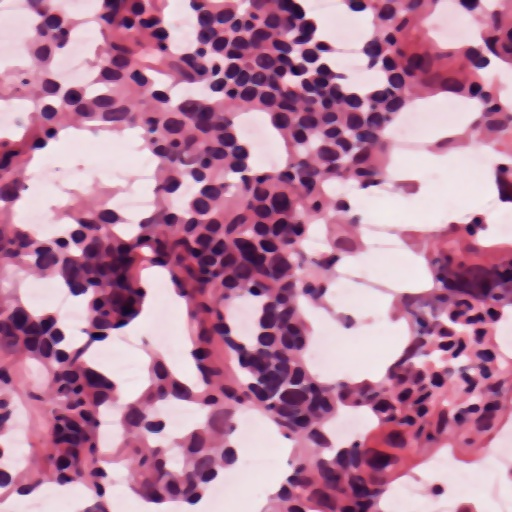
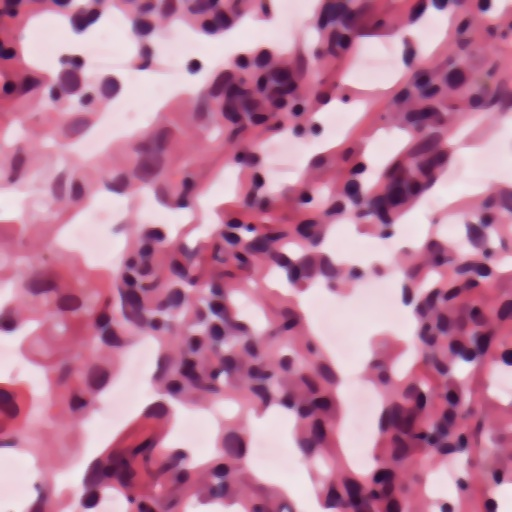
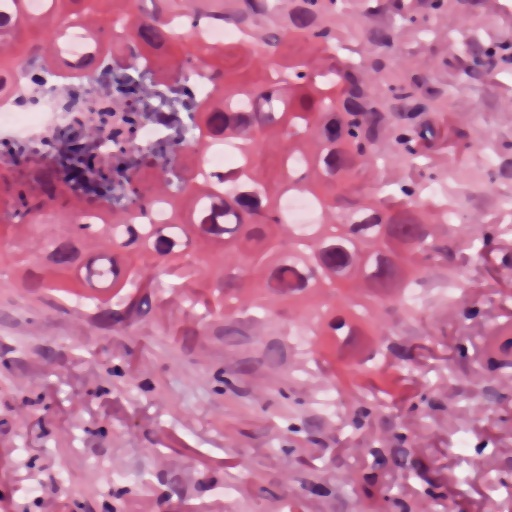
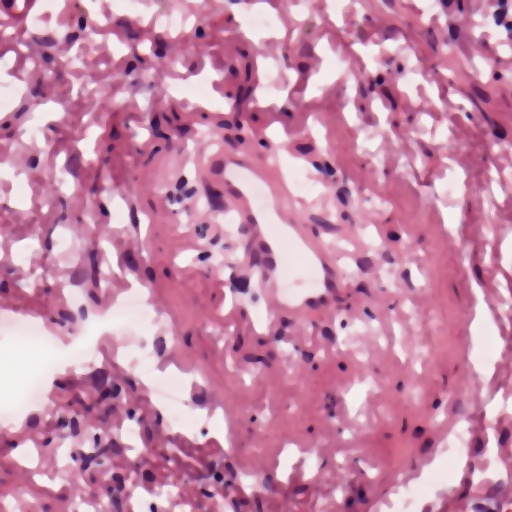
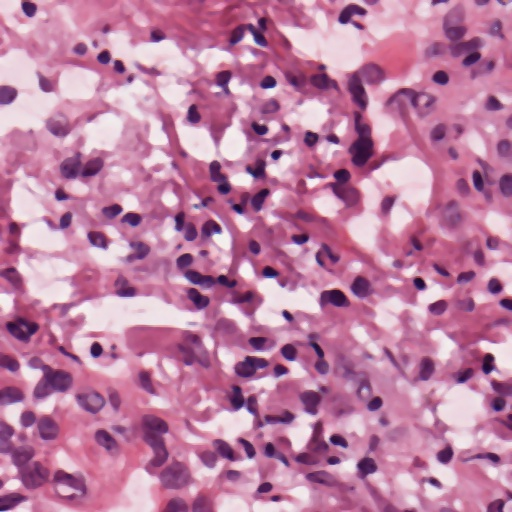
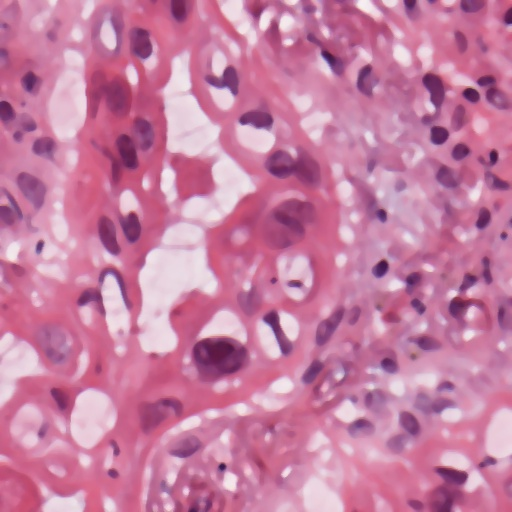
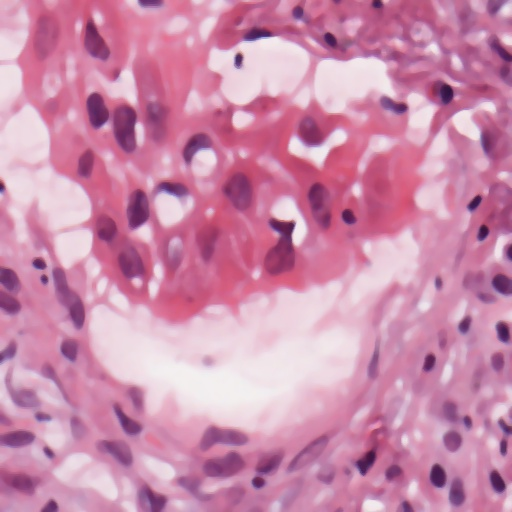
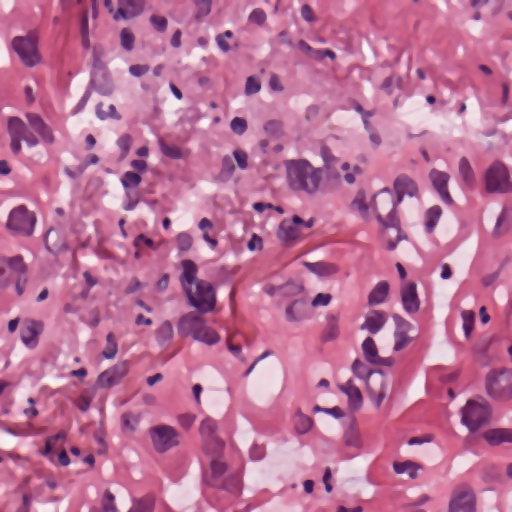
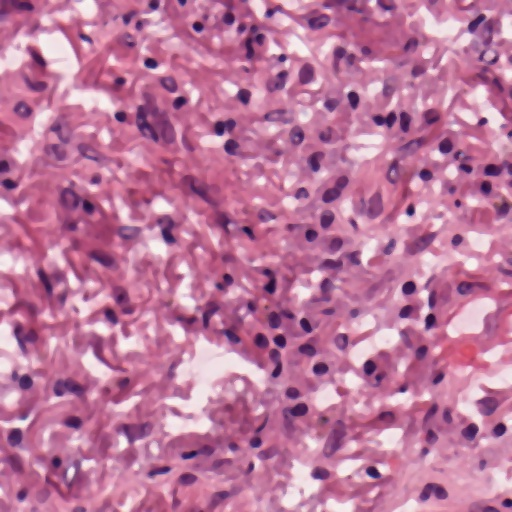
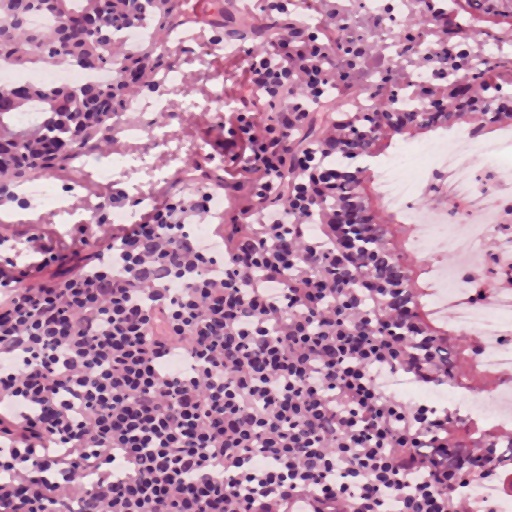
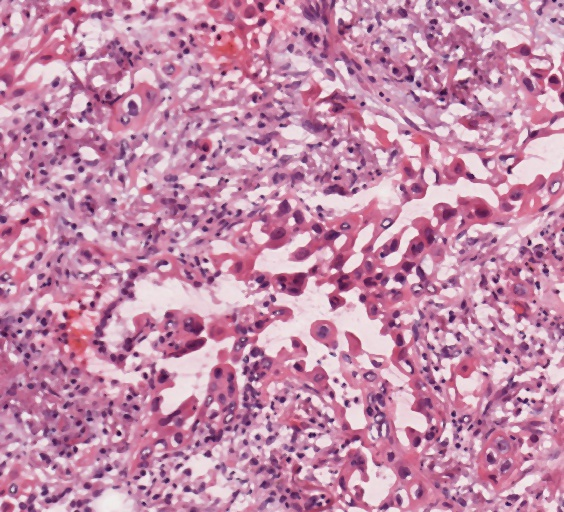
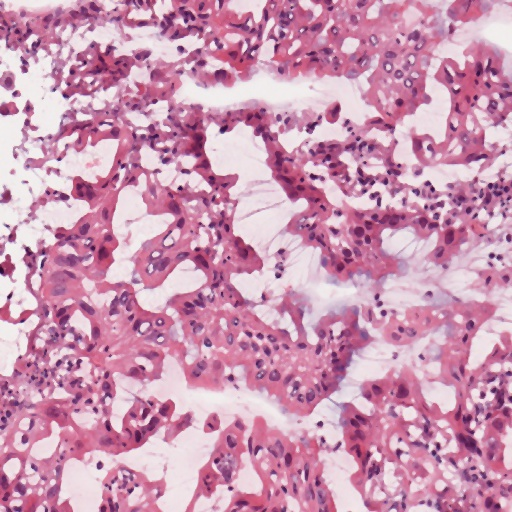
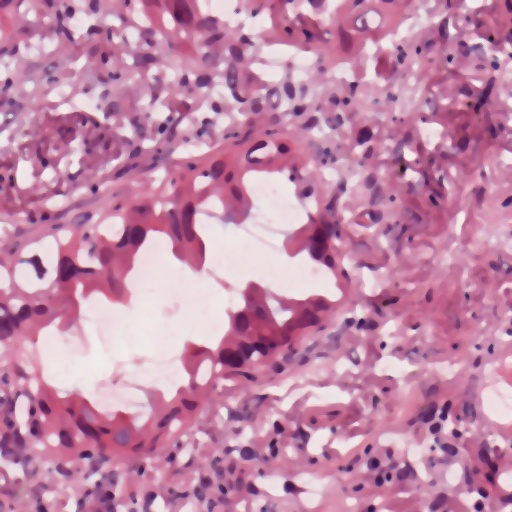
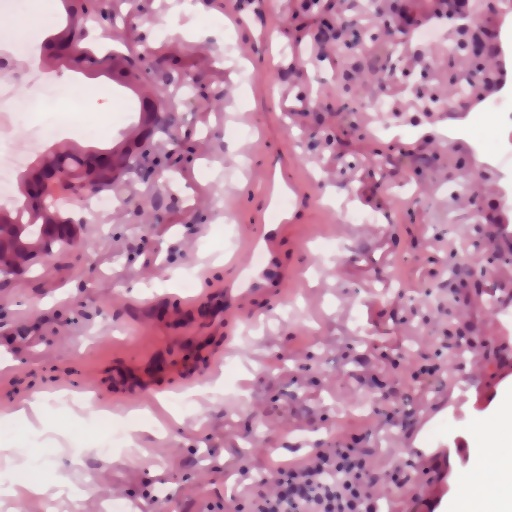
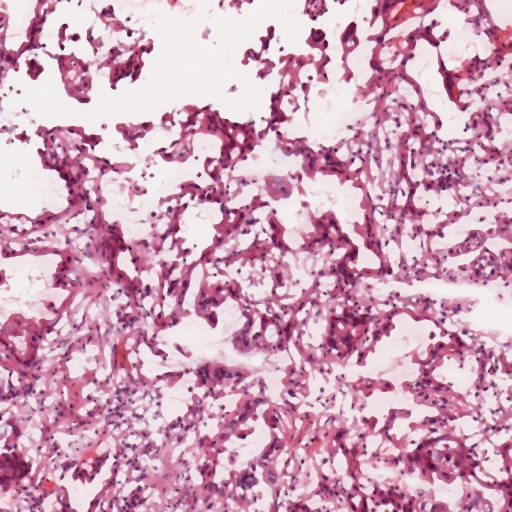
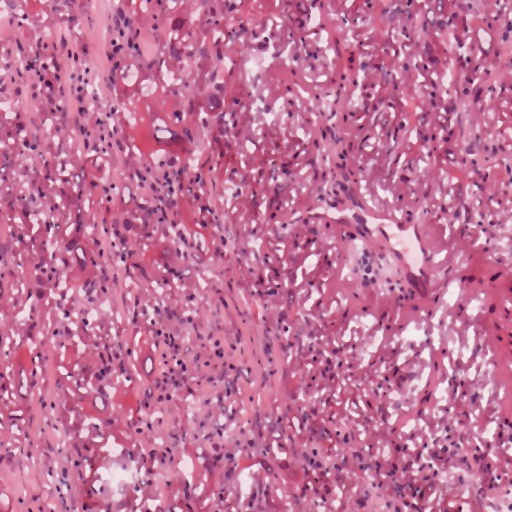

In [ ]:
import os
import cv2
import numpy as np
import base64
import logging
import pandas as pd
from tqdm import tqdm
from skimage.metrics import structural_similarity
from IPython.display import display, HTML

# ===========================
# Configuration
# ===========================
INPUT_ROOT = 'DATASET'
OUTPUT_ROOT = 'DATASET_median'
KERNEL_SIZES = [3, 5, 7]
SSIM_THRESHOLD = 0.85
MAX_PREVIEW = 20
LOG_FILE = 'image_processing.log'

# ===========================
# Logging Setup
# ===========================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    handlers=[
        logging.FileHandler(LOG_FILE),
        logging.StreamHandler()
    ]
)

# ===========================
# Utility Functions
# ===========================
def calculate_ssim(original, denoised):
    """Compute SSIM between grayscale versions of two images."""
    return structural_similarity(original, denoised, data_range=255)

def find_optimal_kernel_median(image):
    """Find the largest median filter kernel that maintains SSIM ≥ threshold."""
    gray_orig = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    best_kernel = 3
    for k in KERNEL_SIZES:
        filtered = cv2.medianBlur(image, k)
        gray_filtered = cv2.cvtColor(filtered, cv2.COLOR_BGR2GRAY)
        if calculate_ssim(gray_orig, gray_filtered) >= SSIM_THRESHOLD:
            best_kernel = k
        else:
            break
    return best_kernel

def encode_image_for_html(img):
    """Convert image to base64 for HTML preview."""
    _, buffer = cv2.imencode('.jpg', img)
    b64 = base64.b64encode(buffer).decode()
    return f'<img src="data:image/jpeg;base64,{b64}" width="100"/>'

def process_image(img_path):
    """Process a single image: filter, calculate SSIM, save, return results."""
    try:
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError("Image could not be read")

        kernel = find_optimal_kernel_median(image)
        denoised = cv2.medianBlur(image, kernel)

        gray_orig = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_denoised = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
        final_ssim = calculate_ssim(gray_orig, gray_denoised)

        split, class_name = img_path.split(os.sep)[-3:-1]
        save_path = os.path.join(OUTPUT_ROOT, split, class_name, os.path.basename(img_path))
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        cv2.imwrite(save_path, denoised)

        return img_path, kernel, final_ssim, denoised

    except Exception as e:
        logging.error(f"Error processing {img_path}: {str(e)}")
        return img_path, None, None, None

# ===========================
# Main Processing
# ===========================
def process_dataset_median():
    report = []
    total_ssim = 0
    processed_count = 0

    # Count all valid images
    total_images = sum(
        len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        for _, _, files in os.walk(INPUT_ROOT)
    )

    with tqdm(total=total_images, desc="🧪 Processing Images", unit="img") as progress:
        for split in os.listdir(INPUT_ROOT):
            split_path = os.path.join(INPUT_ROOT, split)
            if not os.path.isdir(split_path):
                continue

            for class_name in os.listdir(split_path):
                class_path = os.path.join(split_path, class_name)
                if not os.path.isdir(class_path):
                    continue

                for filename in os.listdir(class_path):
                    if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                        continue

                    img_path = os.path.join(class_path, filename)
                    img_path, kernel, ssim_score, denoised = process_image(img_path)

                    if kernel is None:
                        progress.update(1)
                        continue

                    # Generate preview
                    preview = encode_image_for_html(denoised) if processed_count < MAX_PREVIEW else ""

                    # Add to report
                    report.append({
                        'Image': preview,
                        'Path': img_path,
                        'Kernel': f"({kernel}, {kernel})",
                        'SSIM': f"{ssim_score:.4f}"
                    })

                    total_ssim += ssim_score
                    processed_count += 1

                    # Live update in progress bar
                    progress.set_postfix({
                        'last': os.path.basename(img_path),
                        'kernel': kernel,
                        'avg_ssim': f"{total_ssim / processed_count:.4f}"
                    })
                    progress.update(1)

    avg_ssim = total_ssim / processed_count if processed_count > 0 else 0
    return report, avg_ssim

# ===========================
# Reporting
# ===========================
def show_html_table(report, avg_ssim):
    df = pd.DataFrame(report[:MAX_PREVIEW])
    logging.info(f"\n✅ Average SSIM: {avg_ssim:.2%} across {len(report)} images.")
    display(HTML(df.to_html(escape=False, index=False)))

# ===========================
# Entry Point
# ===========================
if __name__ == "__main__":
    report, avg_ssim = process_dataset_median()
    show_html_table(report, avg_ssim)
